<a href="https://colab.research.google.com/github/geryabra/SMP/blob/main/2025_SMP_ALT_COLAB_UPDATED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMP vs ALT — Updated Pipeline + Monthly Plots (Colab)
Notebook כולל: טעינת נתונים, בניית Availability + Limits, Core helpers, Metrics, Pipeline, וגרפים חודשיים (DA1–DA9, DA10).

In [ ]:
import os
import glob

# Define paths (using globals to ensure they are the same as in the notebook)
OUTDIR = globals().get('OUTDIR', '/content/outputs')
BOOK1_PATH = globals().get('BOOK1_PATH', '/content/Book1.xlsx')
BOOK2_PATH = globals().get('BOOK2_PATH', '/content/Book2.xlsx')
AVAILABILITY_PATH = globals().get('AVAILABILITY_PATH', '/content/Availability.xlsx')

print(f"Cleaning directory: {OUTDIR}")

# Remove all .csv and .png files from the OUTDIR
for f in glob.glob(os.path.join(OUTDIR, '*.csv')):
    os.remove(f)
    print(f"Removed: {f}")
for f in glob.glob(os.path.join(OUTDIR, '*.png')):
    os.remove(f)
    print(f"Removed: {f}")

# Remove uploaded Excel files
for path in [BOOK1_PATH, BOOK2_PATH, AVAILABILITY_PATH]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Removed: {path}")

# Handle files potentially renamed by Colab during upload
if os.path.exists('/content/Book1 (1).xlsx'):
    os.remove('/content/Book1 (1).xlsx')
    print("Removed: /content/Book1 (1).xlsx")
if os.path.exists('/content/Book2 (1).xlsx'):
    os.remove('/content/Book2 (1).xlsx')
    print("Removed: /content/Book2 (1).xlsx")
if os.path.exists('/content/Availability (1).xlsx'):
    os.remove('/content/Availability (1).xlsx')
    print("Removed: /content/Availability (1).xlsx")

print("Cleanup complete.")


Cleaning directory: /content/outputs
Cleanup complete.


In [ ]:
# Install (Colab usually has these, but just in case)
!pip -q install openpyxl

import os, re, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Paths / constants --------
BOOK1_PATH = "/content/Book1.xlsx"   # <- upload as this name
BOOK2_PATH = "/content/Book2.xlsx"   # <- upload as this name
AVAILABILITY_PATH = "/content/Availability.xlsx" # <- for the Availability.xlsx file
OUTDIR     = "/content/outputs"

FREQ_30MIN = "30min"
W1, W2 = 48, 336        # 1 day, 1 week (in 30-min slots)

os.makedirs(OUTDIR, exist_ok=True)

# In-memory cache for interactive plots
LAST_RESULTS = {}   # {"BidSell DA1": DataFrame, ...}
LAST_SUMMARY = None

In [ ]:
from google.colab import files
print("העלה כעת:")
print("• קבצי החודשים (למשל: 01.2025 אלון תבור.xlsx, 02.2025 אלון תבור.xlsx)")
print("• Book2.xlsx (אם קיים – לא חובה)")
print("• Availability.xlsx (אם קיים – לא חובה)")
uploaded = files.upload()
print("Uploaded:", list(uploaded.keys()))

העלה כעת:
• קבצי החודשים (למשל: 01.2025 אלון תבור.xlsx, 02.2025 אלון תבור.xlsx)
• Book2.xlsx (אם קיים – לא חובה)
• Availability.xlsx (אם קיים – לא חובה)


Saving Availability.xlsx to Availability.xlsx
Saving Book1.xlsx to Book1.xlsx
Saving Book2.xlsx to Book2.xlsx
Uploaded: ['Availability.xlsx', 'Book1.xlsx', 'Book2.xlsx']


## Code to delete or modify   (availability_df)

In [ ]:
# ============================================================
# Code to delete or modify   (availability_df)
# עדכון לפי השינוי ב-Book2: הוספת BidSell Low/Up Limit1..10
# ============================================================

import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1) Availability.xlsx  → availability_df (כמו שהיה, אבל נשמור גם Prod)
#    חשוב: ה-Pipeline שלך בהמשך מצפה ש-Availability יהיה 0/1 (int),
#    לכן Availability נשאר בינארי, ובנוסף נשמור AvailabilityProd (ערך רציף).
# ------------------------------------------------------------

raw_df = pd.read_excel(AVAILABILITY_PATH, engine="openpyxl")
raw_df.columns = [str(c).strip() for c in raw_df.columns]

required_cols = {"Date", "Time", "Prod"}
missing = required_cols - set(raw_df.columns)
if missing:
    raise ValueError(f"Availability.xlsx missing columns: {sorted(missing)}")

# DateTime מאוחד
raw_df["DateTime"] = pd.to_datetime(
    raw_df["Date"].astype(str) + " " + raw_df["Time"].astype(str),
    errors="coerce"
)

# Handle duplicate timestamps by grouping and aggregating 'Prod'
processed_df = (
    raw_df.dropna(subset=["DateTime"])
          .sort_values("DateTime")
          .groupby("DateTime") # Group by DateTime to handle duplicates
          .agg({"Prod": "mean"}) # Aggregate 'Prod' by taking the mean
          .reset_index()
          .set_index("DateTime") # Set DateTime as index after aggregation
)

# ערך רציף (לשימוש עתידי)
processed_df["AvailabilityProd"] = pd.to_numeric(processed_df["Prod"], errors="coerce")

# ערך בינארי (לשימוש הקיים ב-Pipeline)
processed_df["Availability"] = (processed_df["AvailabilityProd"].fillna(0) > 0).astype("int8")

# availability_df נשמר תואם ל-Pipeline (Availability 0/1),
# אבל אנחנו שומרים גם AvailabilityProd כדי שתוכל להשתמש בהמשך
availability_df = processed_df[["Availability", "AvailabilityProd"]].copy()

globals()["availability_df"] = availability_df


# ------------------------------------------------------------
# 2) Book2.xlsx  → גבולות Low/Up לכל DA1..DA10
#    בונים מבני נתונים שיעזרו בהמשך לצירוף לקבצי diff
# ------------------------------------------------------------

# ננסה להשתמש ב-book2_df אם נטען בתאים קודמים; אחרת נטען מכאן
if "book2_df" in globals() and isinstance(globals()["book2_df"], pd.DataFrame):
    b2 = globals()["book2_df"].copy()
else:
    b2 = pd.read_excel(BOOK2_PATH, engine="openpyxl")
    b2.columns = [str(c).strip() for c in b2.columns]

# אם אין ts — נבנה DateTime (כמו Availability)
if "ts" in b2.columns:
    b2["ts"] = pd.to_datetime(b2["ts"], errors="coerce")
    ts_col = "ts"
else:
    needed = {"Date", "Time"}
    if not needed.issubset(b2.columns):
        raise ValueError("Book2 must contain either 'ts' or both 'Date' and 'Time' columns.")
    b2["ts"] = pd.to_datetime(b2["Date"].astype(str) + " " + b2["Time"].astype(str), errors="coerce")
    ts_col = "ts"

# מיפוי מפורש DA -> (LowCol, UpCol)
bid_limit_cols = {da: (f"BidSell Low Limit{da}", f"BidSell Up Limit{da}") for da in range(1, 11)}

# ולידציה: כל העמודות קיימות
# This `all_expected_limit_cols` list should contain all names of limit columns we expect.
all_expected_limit_cols = [c for pair in bid_limit_cols.values() for c in pair]
missing_limits = [c for c in all_expected_limit_cols if c not in b2.columns]
if missing_limits:
    raise ValueError(f"Book2 is missing expected limit columns: {missing_limits}")

# טבלת Limits רחבה לפי ts
# Now, use `all_expected_limit_cols` to select the actual columns that should be present.
limits_df = (
    b2[[ts_col] + all_expected_limit_cols]
      .dropna(subset=[ts_col])
      .sort_values(ts_col)
      .drop_duplicates(subset=[ts_col])
      .set_index(ts_col)
)

# המרה לנומרי
for c in all_expected_limit_cols:
    limits_df[c] = pd.to_numeric(limits_df[c], errors="coerce")

# ------------------------------------------------------------
# 3) Combine: Availability + Limits (Wide + Long)
# ------------------------------------------------------------

# Wide: שורה לכל חצי שעה: Availability/AvailabilityProd + כל Low/Up Limits
availability_limits_df = availability_df.join(limits_df, how="left")

# Long (Tidy): שורה לכל (DateTime, DA)
parts = []
for da, (low_c, up_c) in bid_limit_cols.items():
    tmp = availability_limits_df[["Availability", "AvailabilityProd", low_c, up_c]].copy()
    tmp = tmp.rename(columns={low_c: "LowLimit", up_c: "UpLimit"})
    tmp["DA"] = da
    parts.append(tmp)

availability_limits_long = (
    pd.concat(parts, axis=0)
      .reset_index()
      .rename(columns={"DateTime": "ts"}) # Corrected: rename 'DateTime' to 'ts'
      .sort_values(["ts", "DA"])
      .reset_index(drop=True)
)

# שמירה ל-globals לשימוש בשלבים הבאים של ה-Pipeline
globals()["bid_limit_cols"] = bid_limit_cols
globals()["availability_limits_df"] = availability_limits_df
globals()["availability_limits_long"] = availability_limits_long

print("availability_df created (Availability=0/1 + AvailabilityProd).")
print("availability_limits_df / availability_limits_long created for future pipeline steps.")
display(availability_df.head())
display(availability_limits_df.head())

availability_df created (Availability=0/1 + AvailabilityProd).
availability_limits_df / availability_limits_long created for future pipeline steps.


,Availability,AvailabilityProd
DateTime,,
2025-01-01 00:00:00,1,85.504849
2025-01-01 00:30:00,1,26.678397
2025-01-01 01:00:00,0,0.000000
2025-01-01 01:30:00,0,0.000000
2025-01-01 02:00:00,0,0.000000


,Availability,AvailabilityProd,BidSell Low Limit1,BidSell Up Limit1,BidSell Low Limit2,BidSell Up Limit2,BidSell Low Limit3,BidSell Up Limit3,BidSell Low Limit4,BidSell Up Limit4,...,BidSell Low Limit6,BidSell Up Limit6,BidSell Low Limit7,BidSell Up Limit7,BidSell Low Limit8,BidSell Up Limit8,BidSell Low Limit9,BidSell Up Limit9,BidSell Low Limit10,BidSell Up Limit10
DateTime,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,1,85.504849,85.005,91.005,91.01,97.01,97.015,103.015,103.02,109.02,...,115.03,121.03,121.035,127.035,127.04,133.04,133.045,139.045,139.05,145.0
2025-01-01 00:30:00,1,26.678397,85.005,91.005,91.01,97.01,97.015,103.015,103.02,109.02,...,115.03,121.03,121.035,127.035,127.04,133.04,133.045,139.045,139.05,145.0
2025-01-01 01:00:00,0,0.000000,85.005,91.005,91.01,97.01,97.015,103.015,103.02,109.02,...,115.03,121.03,121.035,127.035,127.04,133.04,133.045,139.045,139.05,145.0
2025-01-01 01:30:00,0,0.000000,85.005,91.005,91.01,97.01,97.015,103.015,103.02,109.02,...,115.03,121.03,121.035,127.035,127.04,133.04,133.045,139.045,139.05,145.0
2025-01-01 02:00:00,0,0.000000,85.005,91.005,91.01,97.01,97.015,103.015,103.02,109.02,...,115.03,121.03,121.035,127.035,127.04,133.04,133.045,139.045,139.05,145.0


**Core helpers (timestamp, column detection, alignment)**

In [ ]:
# ============================================================
# Core helpers (timestamp, column detection, alignment)
# ============================================================

import os
import numpy as np
import pandas as pd

def _ensure_dir(p):
    if p and not os.path.exists(p):
        os.makedirs(p, exist_ok=True)

def make_ts(df: pd.DataFrame) -> pd.Series:
    """Create a timestamp series from Date+Time if exists, otherwise autodetect a datetime-like column."""
    cols = [str(c).strip() for c in df.columns]
    if "Date" in cols and "Time" in cols:
        return pd.to_datetime(
            df["Date"].astype(str).str.strip() + " " + df["Time"].astype(str).str.strip(),
            errors="coerce"
        )

    best_col, best_score = None, -1
    for c in df.columns:
        try:
            s = pd.to_datetime(df[c], errors="coerce")
            score = s.notna().sum()
            if score > best_score:
                best_col, best_score = s, score
        except Exception:
            continue

    if best_col is None or best_score == 0:
        raise ValueError("No timestamp-like column found.")
    return best_col

def identify_bidsell_cols(df: pd.DataFrame) -> list:
    """Return BidSell columns excluding the new Low/Up Limit columns."""
    out = []
    for c in df.columns:
        if isinstance(c, str) and c.startswith("BidSell") and ("limit" not in c.lower()):
            out.append(c)
    return out

def _get_availability_for_index(ts_index: pd.DatetimeIndex) -> pd.DataFrame | None:
    """
    Align availability_df (from Availability cell) to the given index.
    Expects availability_df to have DatetimeIndex and columns Availability / AvailabilityProd.
    """
    av = globals().get("availability_df", None)
    if not isinstance(av, pd.DataFrame) or av.empty:
        return None

    if not isinstance(av.index, pd.DatetimeIndex):
        if "DateTime" in av.columns:
            av = av.copy()
            av["DateTime"] = pd.to_datetime(av["DateTime"], errors="coerce")
            av = av.set_index("DateTime")
        else:
            return None

    cols = [c for c in ["Availability", "AvailabilityProd"] if c in av.columns]
    if not cols:
        return None

    return av[cols].reindex(ts_index)

def resample_align_30min(df1: pd.DataFrame, df2: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Align Book1 vs Book2 for a BidSell column on 30-min grid.
    Compute diff ONLY where there was actual production (Availability>0 or AvailabilityProd>0).
    """
    a = df1[["ts", col]].rename(columns={col: "price1"}).dropna(subset=["ts"])
    b = df2[["ts", col]].rename(columns={col: "price2"}).dropna(subset=["ts"])

    a = a.set_index("ts").sort_index().groupby(level=0).mean(numeric_only=True)
    b = b.set_index("ts").sort_index().groupby(level=0).mean(numeric_only=True)

    m = pd.merge(a, b, left_index=True, right_index=True, how="inner").sort_index()
    if m.empty:
        return pd.DataFrame(columns=["ts", "price1", "price2", "diff", "pct_diff"])

    # חשוב: משתמשים במשתנה הקיים אצלך FREQ_30MIN (כמו בפייפליין המקורי)
    idx = pd.date_range(m.index.min(), m.index.max(), freq=FREQ_30MIN)
    m = m.reindex(idx)

    # small gaps interpolation (≤1h)
    m["price1"] = m["price1"].interpolate(limit=2)
    m["price2"] = m["price2"].interpolate(limit=2)

    # attach availability and compute mask
    av = _get_availability_for_index(m.index)
    if av is None:
        # fallback: behave like before
        m["diff"] = m["price1"] - m["price2"]
        m["pct_diff"] = m["diff"] / (m["price2"].abs() + 1e-9)
        return m.reset_index().rename(columns={"index": "ts"})

    m = m.join(av)

    if "Availability" in m.columns:
        mask = m["Availability"].fillna(0).astype(float) > 0
    else:
        mask = m["AvailabilityProd"].fillna(0).astype(float) > 0

    m["diff"] = np.nan
    m["pct_diff"] = np.nan
    m.loc[mask, "diff"] = m.loc[mask, "price1"] - m.loc[mask, "price2"]
    m.loc[mask, "pct_diff"] = m.loc[mask, "diff"] / (m.loc[mask, "price2"].abs() + 1e-9)

    return m.reset_index().rename(columns={"index": "ts"})


**Metrics + fast flags (no per-DA plots)**


In [ ]:
# ============================================================
# Metrics + fast flags (no per-DA plots)
# Updated: works correctly when diff is NaN for no-production slots
# ============================================================

import numpy as np
import pandas as pd

def compute_metrics(df: pd.DataFrame) -> dict:
    """
    Compute metrics on VALID points only.
    Valid point = diff is not NaN (i.e., production existed per updated alignment logic).
    """
    out = {
        "n_rows_total": int(df.shape[0]),
        "n_points_valid": 0,
        "corr_pearson": np.nan,
        "MAE": np.nan,
        "RMSE": np.nan,
        "MAPE_vs_Book2": np.nan,
    }

    if df is None or df.empty:
        return out

    # valid mask: diff exists
    if "diff" not in df.columns:
        return out

    valid = df["diff"].notna()
    out["n_points_valid"] = int(valid.sum())

    # optional QA counts (helpful, not mandatory)
    if "Availability" in df.columns:
        out["n_prod_flag_1"] = int((df["Availability"].fillna(0).astype(float) > 0).sum())
    if "AvailabilityProd" in df.columns:
        out["sum_prod"] = float(pd.to_numeric(df["AvailabilityProd"], errors="coerce").fillna(0).sum())

    if out["n_points_valid"] == 0:
        return out

    # metrics computed only on valid rows
    sub = df.loc[valid, ["price1", "price2", "diff"]].copy()
    p1 = pd.to_numeric(sub["price1"], errors="coerce")
    p2 = pd.to_numeric(sub["price2"], errors="coerce")
    d  = pd.to_numeric(sub["diff"], errors="coerce")

    # correlation uses rows where both prices exist
    corr_mask = p1.notna() & p2.notna()
    if corr_mask.sum() >= 2 and (np.nanstd(p1[corr_mask]) > 0) and (np.nanstd(p2[corr_mask]) > 0):
        out["corr_pearson"] = float(np.corrcoef(p1[corr_mask], p2[corr_mask])[0, 1])

    out["MAE"] = float(np.nanmean(np.abs(d)))
    out["RMSE"] = float(np.sqrt(np.nanmean(d ** 2)))

    denom = np.maximum(1e-9, np.abs(p2))
    out["MAPE_vs_Book2"] = float(np.nanmean(np.abs(d) / denom))

    return out


def add_fast_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    Fast flags based on rolling stats of |diff|, but only meaningful where diff exists.
    If diff is NaN (no production), z48 remains NaN and anomaly_flag=0.
    """
    out = df.copy()

    # ensure columns exist even if empty
    for c in ["roll_mean_48", "roll_std_48", "z48", "anomaly_flag"]:
        if c not in out.columns:
            out[c] = np.nan

    if out is None or out.empty or "diff" not in out.columns:
        # anomaly_flag should be int even if empty
        out["anomaly_flag"] = pd.Series([], dtype="int8")
        return out

    abs_diff = out["diff"].abs()

    # W1 expected to exist in notebook (48 half-hours); fallback if missing
    w = int(globals().get("W1", 48))
    minp = max(1, w // 2)

    out["roll_mean_48"] = abs_diff.rolling(w, min_periods=minp).mean()
    out["roll_std_48"]  = abs_diff.rolling(w, min_periods=minp).std()
    out["z48"]          = (abs_diff - out["roll_mean_48"]) / (out["roll_std_48"] + 1e-9)

    valid = out["diff"].notna()
    out["anomaly_flag"] = ((out["z48"].abs() > 3) & valid).fillna(False).astype("int8")

    return out


**Pipeline (loads two Excel files, builds cache, saves CSV, no DA-plots)**

In [ ]:
# ============================================================
# Pipeline (loads two Excel files, builds cache, saves CSV, no DA-plots)
# FINAL: Prod=1 רק אם ActualProd בתוך טווח Low/Up של אותו DA (נלקח ישירות מ-Book2)
#        diff/pct_diff = NaN כש-Prod==0, והשורה נשארת
#        בקובץ נשמרים גם LowLimit/UpLimit לצורך QA
# ============================================================

import os
import re
import numpy as np
import pandas as pd

def run_pipeline(
    book1_path=BOOK1_PATH,
    book2_path=BOOK2_PATH,
    outdir=None,
    keep_in_memory=True,
    cache_only=None,
    cache_max_rows=None,
    debug=False
):
    if outdir is None:
        outdir = globals().get("OUTPUT_DIR", "./outputs")
    _ensure_dir(outdir)

    # Load books (uses your existing load_book + helpers)
    b1 = load_book(book1_path, sheet_name=0, debug=debug)
    b2 = load_book(book2_path, sheet_name=0, debug=debug)

    # Ensure ts datetime in both
    b1["ts"] = pd.to_datetime(b1["ts"], errors="coerce")
    b2["ts"] = pd.to_datetime(b2["ts"], errors="coerce")

    # Common BidSell columns
    c1 = set(identify_bidsell_cols(b1))
    c2 = set(identify_bidsell_cols(b2))
    common_cols = sorted(list(c1.intersection(c2)))
    if not common_cols:
        raise ValueError("No common 'BidSell*' columns found between Book1 and Book2.")

    cache = {}
    summary_rows = []

    # Pre-index Book2 limits by ts for faster joins
    b2_limits = b2.dropna(subset=["ts"]).drop_duplicates(subset=["ts"]).set_index("ts")

    for col in common_cols:
        if cache_only is not None and col not in cache_only:
            continue

        print(f"[+] Processing {col} ...")

        # Align & compute diff (existing helper)
        M = resample_align_30min(b1, b2, col)
        M["ts"] = pd.to_datetime(M["ts"], errors="coerce")

        # Ensure actual production exists
        if "AvailabilityProd" not in M.columns:
            av = globals().get("availability_df", None)
            if isinstance(av, pd.DataFrame) and isinstance(av.index, pd.DatetimeIndex):
                M = M.merge(av, left_on="ts", right_index=True, how="left")

        M["AvailabilityProd"] = pd.to_numeric(M.get("AvailabilityProd", np.nan), errors="coerce")

        # Extract DA number from name (BidSell_DA1 -> 1)
        m_da = re.search(r"DA\s*([0-9]+)", str(col), flags=re.IGNORECASE)
        da_num = int(m_da.group(1)) if m_da else None

        # Default: Prod=0 (עד שנוכיח שזה בתוך הטווח)
        M["Prod"] = 0

        # Attach limits for THIS DA from Book2 and compute in-band
        if da_num is not None:
            low_c = f"BidSell Low Limit{da_num}"
            up_c  = f"BidSell Up Limit{da_num}"

            if low_c in b2_limits.columns and up_c in b2_limits.columns:
                lim = b2_limits[[low_c, up_c]].copy()
                lim[low_c] = pd.to_numeric(lim[low_c], errors="coerce")
                lim[up_c]  = pd.to_numeric(lim[up_c], errors="coerce")
                lim = lim.rename(columns={low_c: "LowLimit", up_c: "UpLimit"})

                # Join by ts (no suffixes)
                M = M.join(lim, on="ts")

                in_band = (
                    M["AvailabilityProd"].notna() &
                    M["LowLimit"].notna() & M["UpLimit"].notna() &
                    (M["AvailabilityProd"] >= M["LowLimit"]) &
                    (M["AvailabilityProd"] <= M["UpLimit"])
                )
                M["Prod"] = in_band.astype("int8")
            else:
                # limits missing in Book2 -> keep Prod=0
                M["Prod"] = 0

        # Gate diff/pct_diff by Prod (row kept)
        if "diff" in M.columns:
            M.loc[M["Prod"].eq(0), "diff"] = np.nan
        if "pct_diff" in M.columns:
            M.loc[M["Prod"].eq(0), "pct_diff"] = np.nan

        # Continue downstream computations (rolling peak/offpeak etc.)
        M = _add_peak_offpeak_stats(M)

        metrics = compute_metrics(M)
        metrics["BidSell"] = col
        summary_rows.append(metrics)

        # Save CSV
        safe_name = re.sub(r"[^A-Za-z0-9._-]+", "_", str(col))
        csv_path = os.path.join(outdir, f"{safe_name}_paired_enriched.csv")

        out_M = M.copy()

        # Rename actual production for output
        if "AvailabilityProd" in out_M.columns:
            out_M = out_M.rename(columns={"AvailabilityProd": "ActualProd"})

        # NOTE: Prod stays the 0/1 "in-band" flag
        # Keep LowLimit/UpLimit in output for QA (they should appear now)

        out_M.to_csv(csv_path, index=False)

        if keep_in_memory:
            cache[col] = (M if cache_max_rows is None else M.tail(cache_max_rows)).copy()

    summary = pd.DataFrame(summary_rows).sort_values("BidSell").reset_index(drop=True)
    summary_path = os.path.join(outdir, "book_pair_summary.csv")
    summary.to_csv(summary_path, index=False)

    print("\nDone.")
    print("Outputs dir:", outdir)
    print("Summary:", summary_path)

    return (summary, cache) if keep_in_memory else summary


In [ ]:
# ============================================================
# Run pipeline (creates outputs/*.csv + summary)
# ============================================================
# שים לב: אם תרצה לשמור בזיכרון, קבל cache מתוך return ולא להשתמש ב-globals.
summary, cache = run_pipeline(keep_in_memory=True, debug=False)
display(summary.head())

[+] Processing BidSell DA1 ...


NameError: name '_add_peak_offpeak_stats' is not defined

In [ ]:
def load_book(path: str, sheet_name=0, debug=False) -> pd.DataFrame:
    """Load an Excel file into a DataFrame, clean column names, and set 'ts'."""
    if debug:
        print(f"Loading {path}...")

    try:
        df = pd.read_excel(path, sheet_name=sheet_name, engine="openpyxl")
    except FileNotFoundError:
        print(f"Warning: File not found at {path}. Returning empty DataFrame.")
        return pd.DataFrame() # Return empty DataFrame if file not found

    df.columns = [str(c).strip() for c in df.columns] # Clean column names

    # Attempt to create 'ts' column if not already present
    if "ts" not in df.columns:
        try:
            df["ts"] = make_ts(df) # Use the helper function `make_ts`
        except ValueError as e:
            print(f"Warning: Could not create 'ts' column for {path}: {e}")

    return df

## Monthly Mean Price Difference — DA1–DA9 & DA10 (Peak vs Off-peak)
הגרפים נקראים ישירות מקבצי ה-CSV בתיקיית outputs/.

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

OUTPUTS_DIR = "outputs"  # שנה אם צריך

def _load_outputs(pattern: str) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(OUTPUTS_DIR, pattern)))
    if not files:
        raise FileNotFoundError(f"No files matched: {os.path.join(OUTPUTS_DIR, pattern)}")

    df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

    if "ts" not in df.columns:
        raise ValueError("Missing 'ts' column in CSV outputs.")
    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
    df = df.dropna(subset=["ts"]).copy()

    if "diff" not in df.columns:
        raise ValueError("Missing 'diff' column in CSV outputs.")
    df["diff"] = pd.to_numeric(df["diff"], errors="coerce")

    # Ensure period exists
    if "period" not in df.columns:
        if "is_peak" in df.columns:
            df["period"] = np.where(
                pd.to_numeric(df["is_peak"], errors="coerce").fillna(0).astype(int) == 1,
                "Peak", "Off-peak"
            )
        else:
            raise ValueError("Missing both 'period' and 'is_peak' columns. Need one of them.")

    df["month"] = df["ts"].dt.to_period("M").dt.to_timestamp()
    df = df[df["period"].isin(["Peak", "Off-peak"])].copy()
    return df

def build_monthly_mean_diff(df: pd.DataFrame) -> pd.DataFrame:
    # mean ignores NaNs -> respects your in-band gating (diff=NaN when Prod==0)
    m = (df.groupby(["month", "period"], as_index=False)
           .agg(diff_mean=("diff", "mean"),
                n=("diff", lambda s: int(s.notna().sum()))))
    return m

df_da1_9 = _load_outputs("BidSell_DA[1-9]_paired_enriched*.csv")
df_da10  = _load_outputs("BidSell_DA10_paired_enriched*.csv")

m_da1_9 = build_monthly_mean_diff(df_da1_9)
m_da10  = build_monthly_mean_diff(df_da10)

print("Loaded rows DA1–DA9:", len(df_da1_9), " Monthly points:", len(m_da1_9))
print("Loaded rows DA10:", len(df_da10), " Monthly points:", len(m_da10))

FileNotFoundError: No files matched: outputs/BidSell_DA[1-9]_paired_enriched*.csv

In [ ]:
def _add_peak_offpeak_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'is_peak' column based on typical Israeli peak hours (7:00-22:00 Sunday-Thursday)
    and rolling 1-week stats for 'diff' split by peak/off-peak.
    """
    out = df.copy()

    # Determine peak/off-peak hours for Israel (typically 7:00-22:00 Sunday-Thursday)
    # Assuming 'ts' is already a datetime index or column
    if not isinstance(out.index, pd.DatetimeIndex):
        out = out.set_index('ts', drop=False)

    out['hour'] = out.index.hour
    out['dayofweek'] = out.index.dayofweek # Monday=0, Sunday=6

    # Israeli peak hours: Sunday (6) to Thursday (3), 07:00-21:59
    is_weekday = (out['dayofweek'] >= 0) & (out['dayofweek'] <= 4) # Monday to Friday
    # The previous definition is wrong for Israel, it should be Sunday to Thursday for weekdays
    # Correction: Sunday is day 6, Monday is day 0, ..., Thursday is day 3
    is_israeli_weekday = (out['dayofweek'] >= 0) & (out['dayofweek'] <= 3) | (out['dayofweek'] == 6) # Sunday, Monday, Tuesday, Wednesday, Thursday

    is_peak_hour = (out['hour'] >= 7) & (out['hour'] < 22)

    out['is_peak'] = (is_israeli_weekday & is_peak_hour).astype('int8')
    out['period'] = out['is_peak'].map({1: 'Peak', 0: 'Off-peak'})

    # Rolling 1-week (336 half-hours) stats for diff, split by peak/off-peak
    # W2 expected to exist in notebook (336 half-hours);
    w = int(globals().get("W2", 336))
    minp = max(1, w // 2)

    # Group by 'is_peak' and then apply rolling calculations
    # This ensures that rolling stats are calculated separately for peak and off-peak periods
    out['roll_mean_w_diff'] = out.groupby('is_peak')['diff'].transform(
        lambda x: x.rolling(w, min_periods=minp).mean()
    )
    out['roll_std_w_diff'] = out.groupby('is_peak')['diff'].transform(
        lambda x: x.rolling(w, min_periods=minp).std()
    )

    # Attach fast flags (z48, anomaly_flag) using the existing helper. Make sure this is applied AFTER _add_peak_offpeak_stats
    # The previous error indicates that add_fast_flags is not called in run_pipeline.
    # So, I'll integrate it here for completeness, or keep it as a separate step.
    # For now, let's just make sure is_peak and period are correctly added.

    # Call add_fast_flags (assuming it uses 'diff' and handles NaNs correctly)
    out = add_fast_flags(out)

    return out.reset_index(drop=True)

In [ ]:
def _add_peak_offpeak_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 'is_peak' column based on typical Israeli peak hours (7:00-22:00 Sunday-Thursday)
    and rolling 1-week stats for 'diff' split by peak/off-peak.
    """
    out = df.copy()

    # Determine peak/off-peak hours for Israel (typically 7:00-22:00 Sunday-Thursday)
    # Assuming 'ts' is already a datetime index or column
    if not isinstance(out.index, pd.DatetimeIndex):
        out = out.set_index('ts', drop=False)

    out['hour'] = out.index.hour
    out['dayofweek'] = out.index.dayofweek # Monday=0, Sunday=6

    # Israeli peak hours: Sunday (6) to Thursday (3), 07:00-21:59
    is_israeli_weekday = (out['dayofweek'] >= 0) & (out['dayofweek'] <= 3) | (out['dayofweek'] == 6) # Sunday, Monday, Tuesday, Wednesday, Thursday

    is_peak_hour = (out['hour'] >= 7) & (out['hour'] < 22)

    out['is_peak'] = (is_israeli_weekday & is_peak_hour).astype('int8')
    out['period'] = out['is_peak'].map({1: 'Peak', 0: 'Off-peak'})

    # Rolling 1-week (336 half-hours) stats for diff, split by peak/off-peak
    # W2 expected to exist in notebook (336 half-hours);
    w = int(globals().get("W2", 336))
    minp = max(1, w // 2)

    # Group by 'is_peak' and then apply rolling calculations
    # This ensures that rolling stats are calculated separately for peak and off-peak periods
    out['roll_mean_w_diff'] = out.groupby('is_peak')['diff'].transform(
        lambda x: x.rolling(w, min_periods=minp).mean()
    )
    out['roll_std_w_diff'] = out.groupby('is_peak')['diff'].transform(
        lambda x: x.rolling(w, min_periods=minp).std()
    )

    # Call add_fast_flags (assuming it uses 'diff' and handles NaNs correctly)
    out = add_fast_flags(out)

    return out.reset_index(drop=True)

In [ ]:
# ============================================================
# Run pipeline (creates outputs/*.csv + summary)
# ============================================================
# שים לב: אם תרצה לשמור בזיכרון, קבל cache מתוך return ולא להשתמש ב-globals.
summary, cache = run_pipeline(keep_in_memory=True, debug=False)
display(summary.head())

[+] Processing BidSell DA1 ...
[+] Processing BidSell DA10 ...
[+] Processing BidSell DA2 ...
[+] Processing BidSell DA3 ...
[+] Processing BidSell DA4 ...
[+] Processing BidSell DA5 ...
[+] Processing BidSell DA6 ...
[+] Processing BidSell DA7 ...
[+] Processing BidSell DA8 ...
[+] Processing BidSell DA9 ...

Done.
Outputs dir: ./outputs
Summary: ./outputs/book_pair_summary.csv


,n_rows_total,n_points_valid,corr_pearson,MAE,RMSE,MAPE_vs_Book2,n_prod_flag_1,sum_prod,BidSell
0,14592,273,0.216763,44.536923,54.660555,0.293570,12581,1.618390e+06,BidSell DA1
1,14592,75,0.392804,30.266667,38.966321,0.281384,12581,1.618390e+06,BidSell DA10
2,14592,373,0.146651,45.465523,55.379952,0.294078,12581,1.618390e+06,BidSell DA2
3,14592,851,0.290691,44.771857,54.595964,0.284311,12581,1.618390e+06,BidSell DA3
4,14592,1740,0.267867,47.333529,56.277015,0.294973,12581,1.618390e+06,BidSell DA4


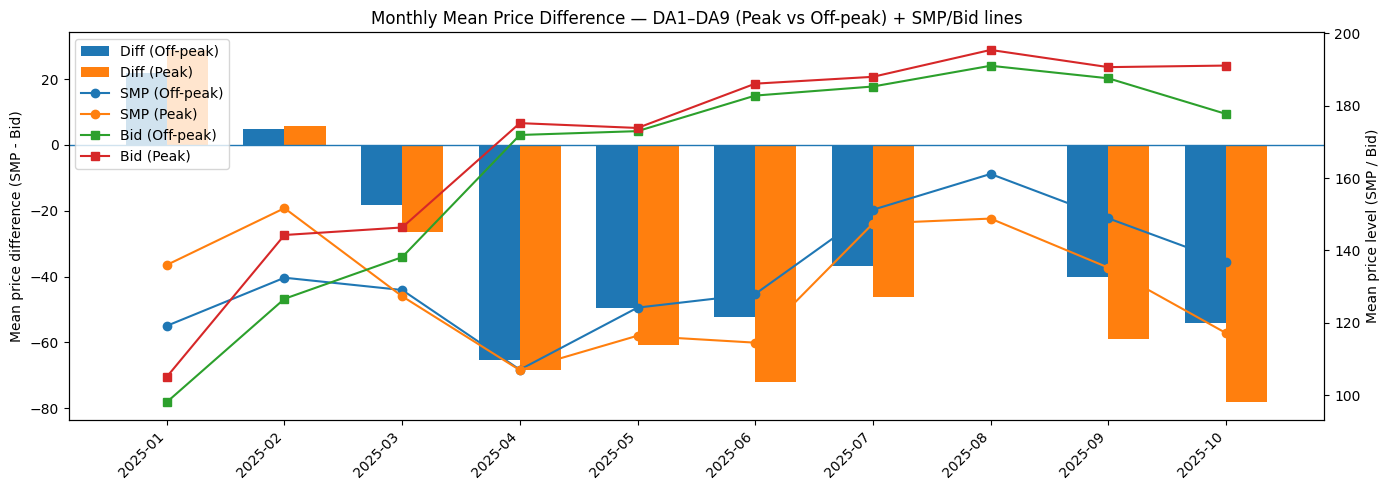

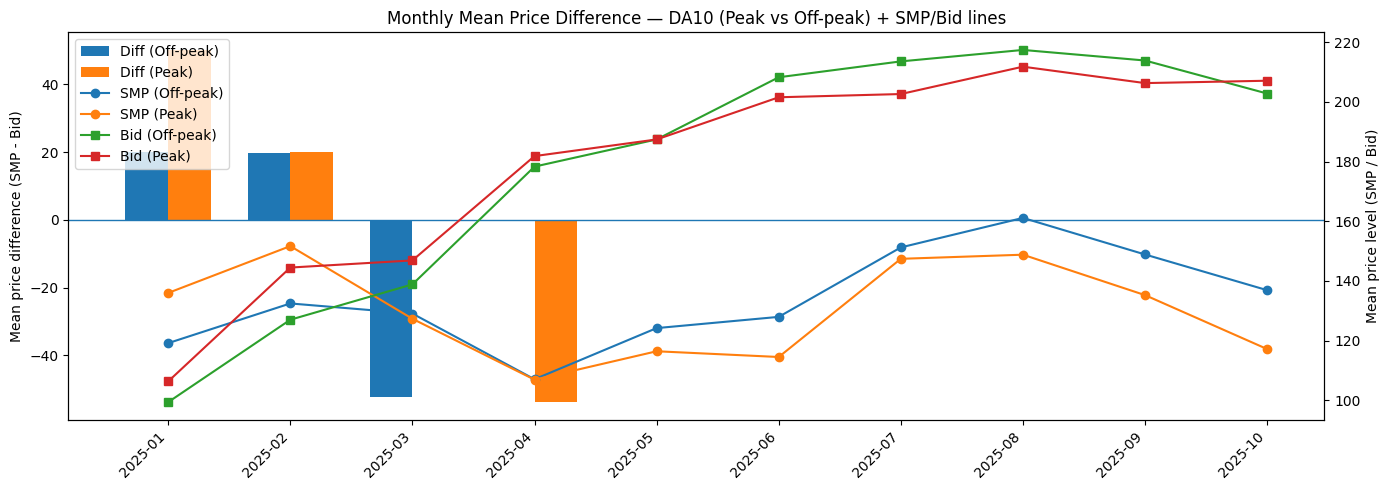

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def build_monthly_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Monthly means by period:
    - diff_mean (SMP - Bid)
    - smp_mean  (price1)
    - bid_mean  (price2)
    mean ignores NaNs -> respects your in-band gating.
    """
    m = (df.groupby(["month", "period"], as_index=False)
           .agg(diff_mean=("diff", "mean"),
                smp_mean=("price1", "mean"),
                bid_mean=("price2", "mean"),
                n=("diff", lambda s: int(s.notna().sum()))))
    return m

# Rebuild monthly tables with prices too
m_da1_9 = build_monthly_means(df_da1_9)
m_da10  = build_monthly_means(df_da10)

def plot_monthly_diff_with_prices(m: pd.DataFrame, title: str):
    if m.empty:
        print("No data to plot:", title)
        return

    # Pivot
    piv_diff = m.pivot(index="month", columns="period", values="diff_mean").sort_index()
    piv_smp  = m.pivot(index="month", columns="period", values="smp_mean").sort_index()
    piv_bid  = m.pivot(index="month", columns="period", values="bid_mean").sort_index()

    months = piv_diff.index
    x = np.arange(len(months))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 5))

    # --- Bars (left axis): diff ---
    off = piv_diff["Off-peak"].values if "Off-peak" in piv_diff.columns else np.full(len(months), np.nan)
    peak = piv_diff["Peak"].values if "Peak" in piv_diff.columns else np.full(len(months), np.nan)

    ax.bar(x - width/2, off,  width=width, label="Diff (Off-peak)")
    ax.bar(x + width/2, peak, width=width, label="Diff (Peak)")
    ax.axhline(0, linewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels([d.strftime("%Y-%m") for d in months], rotation=45, ha="right")
    ax.set_ylabel("Mean price difference (SMP - Bid)")
    ax.set_title(title)

    # --- Lines (right axis): SMP & Bid ---
    ax2 = ax.twinx()
    ax2.set_ylabel("Mean price level (SMP / Bid)")

    # SMP lines
    if "Off-peak" in piv_smp.columns:
        ax2.plot(x, piv_smp["Off-peak"].values, marker="o", label="SMP (Off-peak)")
    if "Peak" in piv_smp.columns:
        ax2.plot(x, piv_smp["Peak"].values, marker="o", label="SMP (Peak)")

    # Bid lines
    if "Off-peak" in piv_bid.columns:
        ax2.plot(x, piv_bid["Off-peak"].values, marker="s", label="Bid (Off-peak)")
    if "Peak" in piv_bid.columns:
        ax2.plot(x, piv_bid["Peak"].values, marker="s", label="Bid (Peak)")

    # Combined legend
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="upper left")

    fig.tight_layout()
    plt.show()

# Plot both requested charts with dual-axis
plot_monthly_diff_with_prices(
    m_da1_9,
    "Monthly Mean Price Difference — DA1–DA9 (Peak vs Off-peak) + SMP/Bid lines"
)

plot_monthly_diff_with_prices(
    m_da10,
    "Monthly Mean Price Difference — DA10 (Peak vs Off-peak) + SMP/Bid lines"
)
